# Neural Network Evaluation
Now we  want to test that our methodology is working well. The best way to do this is to see how our neural network selection works on a similar decay. In this case via a $J/\psi$.

In [ ]:
#"/disk/moose/lhcb/djdt/Lb2L1520mueTuples/realData/2016MD/halfSampleOct2021/blindedTriggeredL1520Selec-collision-firstHalf2016MD-pKmue_Fullv9.root"
#"/disk/moose/lhcb/djdt/Lb2L1520mueTuples/MC/2016MD/fullSampleOct2021/job207-CombDVntuple-15314000-MC2016MD_Full-pKmue-MC.root" <-- OLD PATHS
# [[4500, 5200], [5800, 6500]]

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
plt.style.use([hep.style.ROOT, hep.style.firamath])

In [ ]:
version = '0.0.1'
#train = pd.read_csv(f'../data_files/{version}/all.csv', index_col=[0])
#X_train = train.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
#y_train = train.category

#val = pd.read_csv(f'../data_files/{version}/val.csv', index_col=[0])
#X_val = val.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
#y_val = val.category

#test = pd.read_csv(f'../data_files/{version}/test.csv', index_col=[0])
#X_test = test.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
#y_test = test.category

In [ ]:
df = pd.read_csv(f'../data_files/{version}/all.csv', index_col=[0])
df.dropna(inplace=True)
h, bins = np.histogram(df['Lb_M'], bins=130)

fig, ax = plt.subplots(1, 1)
hep.histplot(h, bins, ax=ax, label='Before Cut')
plt.ylabel('Frequency')
plt.xlabel(r'Invariant Mass $MeV/c^2$')
plt.title('Mass Distribution')
plt.legend()
plt.show()

In [33]:
fs = ['JPs_FD_ORIVX', 'LStar_ORIVX_CHI2', 'Lb_ENDVERTEX_CHI2',
       'LN_Lb_IPCHI2_OWNPV', 'Lb_PT', 'LN_Lb_MINIPCHI2', 'LN_Lb_IP01',
       'LN_Lb_IP23', 'LN_Lb_IP_OWNPV', 'p_TRACK_VeloCHI2NDOF', 'Lb_TAUERR',
       'K_TRACK_VeloCHI2NDOF', 'LN_Lb_DTF_PV_chi2', 'JPs_ORIVX_CHI2',
       'L1_TRACK_VeloCHI2NDOF', 'L2_TRACK_CHI2NDOF', 'JPs_IP_TOPPV',
       'LStar_IP_ORIVX', 'JPs_IP_ORIVX', 'LN_SUM_CONEISO', 'LN_SUM_IPCHI2',
       'LN_COS_THETA', 'LN_COS_LBDIRA']

preds = orig_model.predict(df[fs])

In [34]:
new_df = df.copy()
new_df['pred'] = preds
new_df['pred'].value_counts()

1.0    62953
Name: pred, dtype: int64

## Evaluate without Re-Training

In [22]:
orig_model = tf.keras.models.load_model('../neural_network/models/v7.0.2')
orig_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                384       
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2

In [16]:
pred_train, pred_val, pred_test = orig_model.predict(X_train).flatten(), orig_model.predict(X_val).flatten(), orig_model.predict(X_test).flatten()

2022-03-11 14:07:24.517573: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-11 14:07:24.531662: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400145000 Hz


In [35]:
train_classes_predicted = np.where(pred_train > 0.5, 1, 2)
train_purity = np.count_nonzero(np.logical_and(train_classes_predicted, y_train))/np.unique(train_classes_predicted, return_counts=True)[1][1]

In [36]:
accuracy_score(y_train, np.where(pred_train>0.5,1,0)), roc_auc_score(y_train, pred_train), train_purity

(0.827625470789174, 0.9144038265061658, 1.0400819858802095)

In [37]:
bins = np.linspace(0, 1, 41)
h = [np.histogram(pred_train, bins=bins, density=True)[0], np.histogram(pred_val, bins=bins, density=True)[0], np.histogram(pred_test, bins=bins, density=True)[0]]

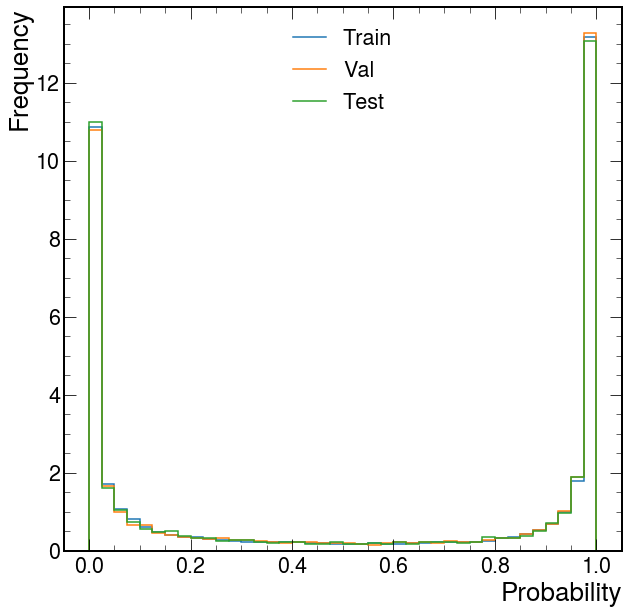

In [38]:
fig, ax = plt.subplots(1, 1)
hep.histplot(h, bins, ax=ax, label=['Train', 'Val', 'Test'], stack=False)
plt.ylabel('Frequency')
plt.xlabel('Probability')
plt.legend(loc='upper center')
plt.show()

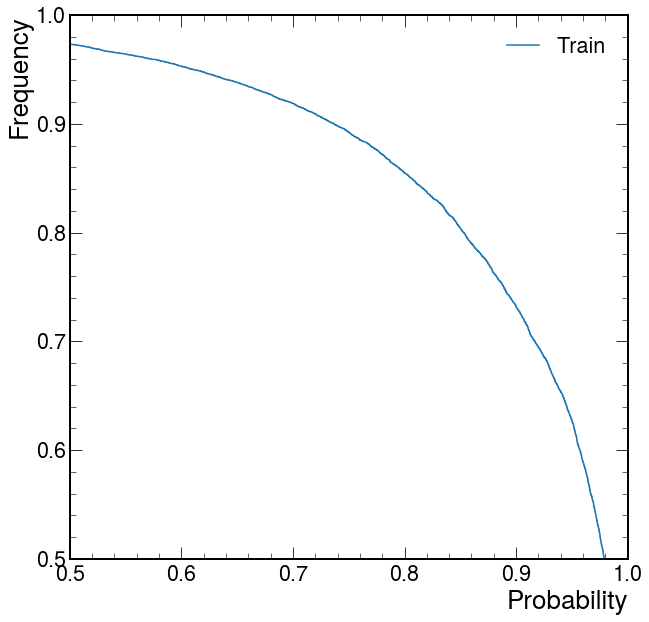

In [24]:
roc = roc_curve(y_train, pred_train)

fig, ax = plt.subplots(1, 1)
ax.plot(roc[1], 1-roc[0], label='Train')
ax.set_xlim(0.5, 1)
ax.set_ylim(0.5, 1)
plt.ylabel('Frequency')
plt.xlabel('Probability')
plt.legend()
plt.show()

## Evaluate with Retraining ~ 86%

In [36]:
from tensorflow.keras import callbacks

custom_callbacks = [
    callbacks.EarlyStopping(patience=20, min_delta=0.0005, restore_best_weights=True), 
    callbacks.ReduceLROnPlateau(patience=5, factor=0.2, min_lr=0.001)
    ]

# Recompile
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01), loss='binary_crossentropy', metrics=['binary_accuracy', 'AUC'])

history = model.fit(X_train, y_train, epochs=100, batch_size=512, validation_data=(X_val, y_val), callbacks=custom_callbacks, verbose=1)

Epoch 1/100
90/90 [==============================] - 4s 24ms/step - loss: 0.5753 - binary_accuracy: 0.8417 - auc: 0.9206 - val_loss: 0.5801 - val_binary_accuracy: 0.8728 - val_auc: 0.9555
Epoch 2/100
85/90 [===========================>..] - ETA: 0s - loss: 0.3724 - binary_accuracy: 0.8731 - auc: 0.9448

KeyboardInterrupt: 

## From Scratch

In [37]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.regularizers import l1_l2

model = Sequential([
        layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l1_l2(0.001, 0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=l1_l2(0.001, 0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_regularizer=l1_l2(0.001, 0.001)),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['binary_accuracy', 'AUC'])

history = model.fit(X_train, y_train, epochs=100, batch_size=512, validation_data=(X_val, y_val), callbacks=custom_callbacks, verbose=1)

Epoch 1/100
90/90 [==============================] - 3s 20ms/step - loss: 0.9832 - binary_accuracy: 0.7310 - auc: 0.8092 - val_loss: 0.8901 - val_binary_accuracy: 0.8238 - val_auc: 0.9188
Epoch 2/100
90/90 [==============================] - 1s 15ms/step - loss: 0.7598 - binary_accuracy: 0.8227 - auc: 0.9007 - val_loss: 0.6920 - val_binary_accuracy: 0.8596 - val_auc: 0.9377
Epoch 3/100
90/90 [==============================] - 1s 13ms/step - loss: 0.6430 - binary_accuracy: 0.8453 - auc: 0.9211 - val_loss: 0.5808 - val_binary_accuracy: 0.8666 - val_auc: 0.9462
Epoch 4/100
90/90 [==============================] - 1s 14ms/step - loss: 0.5621 - binary_accuracy: 0.8576 - auc: 0.9311 - val_loss: 0.5112 - val_binary_accuracy: 0.8753 - val_auc: 0.9517
Epoch 5/100
90/90 [==============================] - 1s 13ms/step - loss: 0.4982 - binary_accuracy: 0.8650 - auc: 0.9386 - val_loss: 0.4592 - val_binary_accuracy: 0.8820 - val_auc: 0.9548
Epoch 6/100
90/90 [==============================] - 1s 14ms

KeyboardInterrupt: 

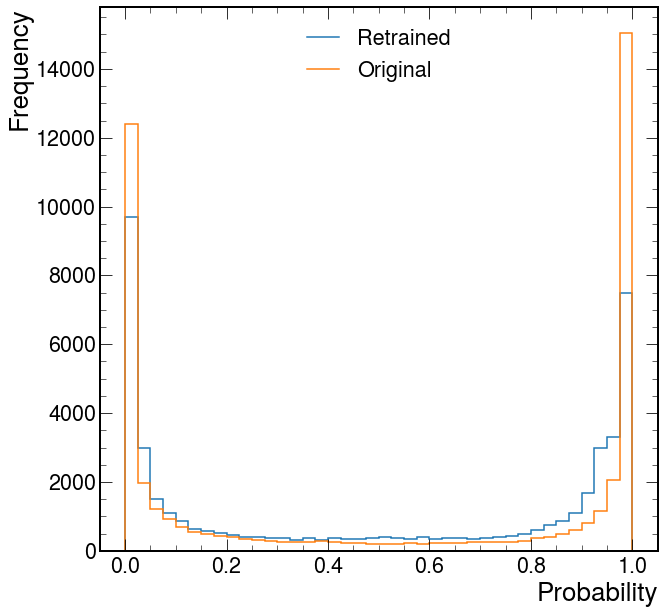

In [39]:
h = [np.histogram(model.predict(X_train).flatten(), bins)[0], np.histogram(orig_model.predict(X_train).flatten(), bins)[0]]

fig, ax = plt.subplots(1, 1)
hep.histplot(h, bins, ax=ax, label=['Retrained', 'Original'], stack=False)
plt.ylabel('Frequency')
plt.xlabel('Probability')
plt.legend(loc='upper center')
plt.show()